In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)

In [37]:
# Load the data
df = pd.read_csv(r"C:\Users\T PLUG\Downloads\data 1 (4)\data\bank-additional-full.csv", sep=';')
df.columns = df.columns.str.strip()  # Clean column names")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### 1. EDA


In [38]:
# Show general info
print(df.info())
print("\nClass Distribution:\n", df['y'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

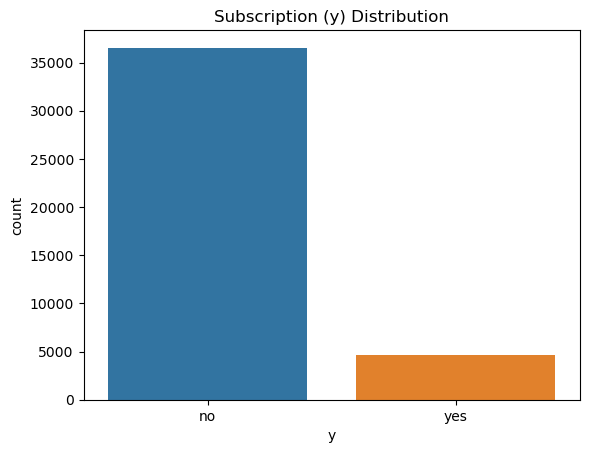

In [39]:
# Plot class distribution
sns.countplot(data=df, x='y')
plt.title('Subscription (y) Distribution')
plt.show()

In [40]:
# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [41]:
# Describe numeric columns
print("\nNumerical Summary:\n", df.describe())


Numerical Summary:
                age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.5788

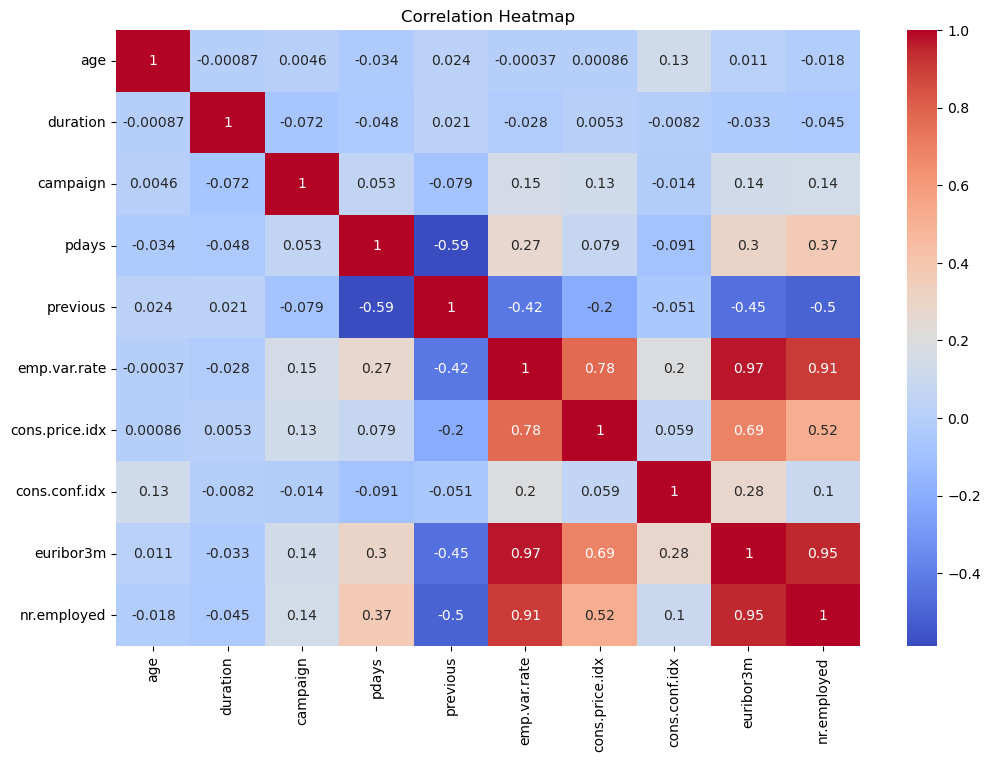

In [42]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### 2. Data Preprocessing

In [55]:
def wrangle(df: pd.DataFrame) -> (pd.DataFrame, pd.Series):

    df = df.copy()  # avoid modifying original

    # Drop constant or uninformative features
    drop_cols = ['contact', 'day','contact', 'balance', 'month', 'day_of_week', 'emp.var.rate',
             'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
    df = df.drop(columns=drop_cols, errors='ignore')

    # Convert target
    if 'y' in df.columns:
        df['y'] = df['y'].map({'yes': 1, 'no': 0})
        y = df['y']
        df.drop(columns=['y'], inplace=True)
    else:
        y = None

    # Replace 'unknown' with NaN
    df.replace("unknown", np.nan, inplace=True)

    # Fill numeric NaNs with median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    # Fill remaining categorical NaNs with 'missing'
    df = df.fillna('missing')

    # One-hot encode categorical variables
    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    return df, y

In [56]:
X, y = wrangle(df)

# # Separate features and target
# X = df.drop('y', axis=1)
# y = df['y']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

### 3. Modeling

In [57]:
# Train Random Forest
model = RandomForestClassifier(n_estimators=50, max_depth=6, random_state=42)
model.fit(X_train_scaled, y_train_res)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92      7310
           1       0.41      0.59      0.48       928

    accuracy                           0.86      8238
   macro avg       0.68      0.74      0.70      8238
weighted avg       0.88      0.86      0.87      8238

Accuracy: 0.8573682932750668
Precision: 0.40804169769173493
Recall: 0.5905172413793104
F1 Score: 0.48260678115367683


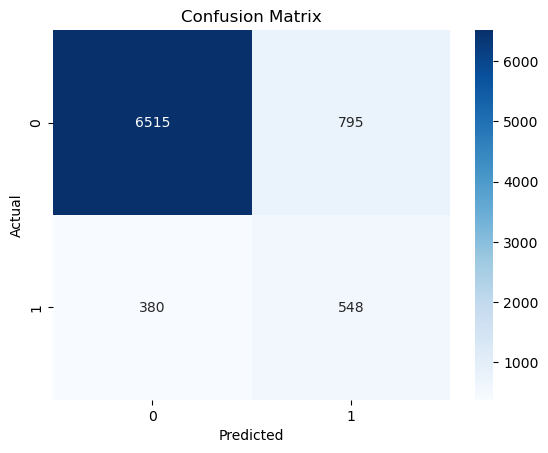

In [58]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

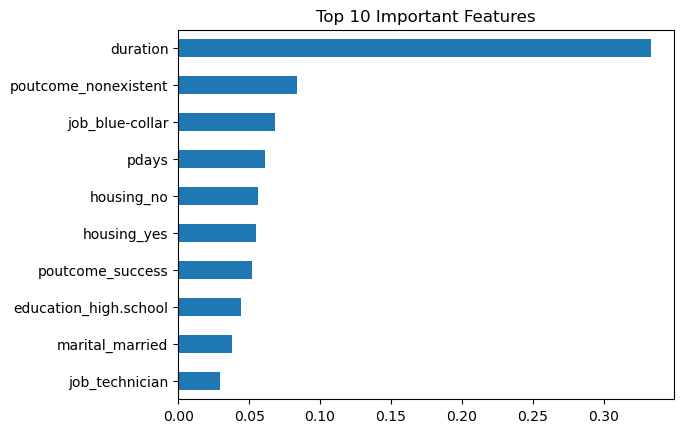

In [59]:
# Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances.head(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()

In [60]:
import joblib

# Save the trained Random Forest model to a file
joblib.dump(model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [36]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

In [47]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
